In [ ]:
# libraries and environment variables set up

# General imports
import os
import operator
from typing import Annotated, Any, Dict, List, Optional, Sequence, TypedDict
import functools

# Langchain imports
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool, Tool
from langchain_experimental.tools import PythonREPLTool
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_community.utilities import OpenWeatherMapAPIWrapper
from langchain.agents import AgentExecutor, create_openai_tools_agent,load_tools
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langchain.chains import LLMMathChain
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import StateGraph, END


# For visualization of the graph, Optional
from IPython.display import Image
import pygraphviz
from IPython.display import Image


## Environment variables
OPENAI_API_KEY="sk-xxx72PEfA4Sje6JCEbYlTxxxxFJT6jedwQaXRwzP1IsaCfE" # https://platform.openai.com/account/api-keys
TAVILY_API_KEY="tvly-5EUhvxxxxDcB9kCWjX2xxxxJemv1NbtPUPH" # https://tavily.com/account/api-keys
LANGCHAIN_API_KEY="ls__e53cd94xxxxx48e5ad72283d5f04ef4e" # https://langchain.com/account/api-keys
OPENWEATHERMAP_API_KEY="aa6efca962xxxxddfb935xxxx6f41ae" # https://home.openweathermap.org/api_keys

os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY
os.environ['LANGCHAIN_API_KEY'] = LANGCHAIN_API_KEY
os.environ['OPENWEATHERMAP_API_KEY'] = OPENWEATHERMAP_API_KEY

# Optional, add tracing in LangSmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Agent-Supervisor"

In [19]:
## Tools and llm setup
llm = ChatOpenAI(model="gpt-4-1106-preview")

# Weather tools
weather_tool = load_tools(["openweathermap-api"], llm)
# Tavily tools - Search tools
tavily_tool = TavilySearchResults(max_results=5)

### Math tools
problem_chain = LLMMathChain.from_llm(llm=llm)
math_tool = Tool.from_function(name="Calculator",func=problem_chain.run,description=\
                               "Useful for when you need to answer questions \
about math. This tool is only for math questions and nothing else. Only input\
math expressions.")

# Python REPL tool 
python_repl_tool = PythonREPLTool()

In [21]:

def create_agent(llm: ChatOpenAI, tools: list, system_prompt: str):
    # Each worker node will be given a name and some tools.
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

In [23]:

members = ["Researcher", "Coder", "Weather", "Calculator"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = ["FINISH"] + members
# Using openai function calling can make output parsing easier for us
function_def = {
    "name": "route",
    "description": "Select the next role.",
    "parameters": {
        "title": "routeSchema",
        "type": "object",
        "properties": {
            "next": {
                "title": "Next",
                "anyOf": [
                    {"enum": options},
                ],
            }
        },
        "required": ["next"],
    },
}
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

llm = ChatOpenAI(model="gpt-4-1106-preview")

supervisor_chain = (
    prompt
    | llm.bind_functions(functions=[function_def], function_call="route")
    | JsonOutputFunctionsParser()
)

In [24]:
options

['FINISH', 'Researcher', 'Coder', 'Weather', 'Calculator']

In [25]:
# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    next: str

research_agent = create_agent(llm, [tavily_tool], "You are a web researcher.")
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION. PROCEED WITH CAUTION
code_agent = create_agent(
    llm,
    [python_repl_tool],
    "You may generate safe python code to analyze data and generate charts using matplotlib.",
)
code_node = functools.partial(agent_node, agent=code_agent, name="Coder")

#Weather nodes 
weather_agent = create_agent(
    llm,
    weather_tool,
    "You are a weather finder. You can provide weather information for a given location.",
)
weather_node = functools.partial(agent_node, agent=weather_agent, name="Weather")

# Math node

math_agent = create_agent(
    llm,
    [math_tool],
    "Useful for when you need to answer questions about math",
)
math_node = functools.partial(agent_node, agent=math_agent, name="Calculator")


In [26]:
workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Coder", code_node)
workflow.add_node("Weather", weather_node)
workflow.add_node("Calculator", math_node)
workflow.add_node("supervisor", supervisor_chain)

for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "supervisor")
# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)
# Finally, add entrypoint
workflow.set_entry_point("supervisor")

graph = workflow.compile()

In [70]:
conditional_map

{'Researcher': 'Researcher',
 'Coder': 'Coder',
 'Weather': 'Weather',
 'Calculator': 'Calculator',
 'FINISH': '__end__'}

/opt/anaconda3/envs/langchain/lib/python3.12/site-packages/pygraphviz/agraph.py:1407: RuntimeWarning: Error: Unknown HTML element <lambda> on line 1 
in label of node supervisor_<lambda>

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


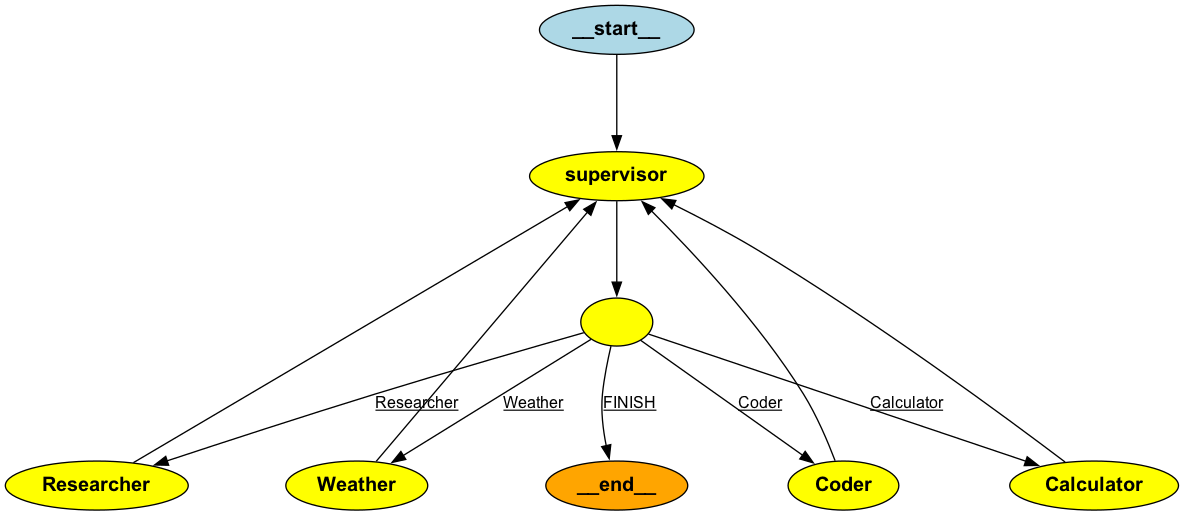

In [27]:
# Graph Visualization
os.environ["PATH"] += os.pathsep + '/opt/homebrew/bin'
Image(graph.get_graph().draw_png())

{'supervisor': {'next': 'Coder'}}
----


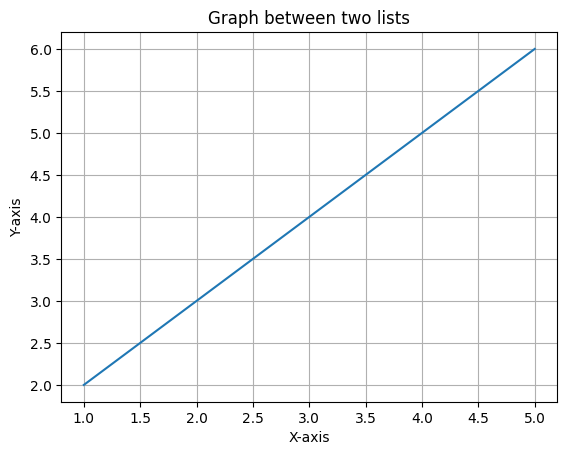

{'Coder': {'messages': [HumanMessage(content="I have generated the code to create a graph between the two lists. However, since I'm unable to directly display images or graphs here, you would need to run the following code in your local Python environment to see the graph:\n\n```python\nimport matplotlib.pyplot as plt\n\nx = [1, 2, 3, 4, 5]\ny = [2, 3, 4, 5, 6]\n\nplt.plot(x, y)\nplt.xlabel('X-axis')\nplt.ylabel('Y-axis')\nplt.title('Graph between two lists')\nplt.grid(True)\nplt.show()\n```\n\nThis code will create a simple line graph with the first list on the X-axis and the second list on the Y-axis. It will also label the axes and add a title and grid to the graph. When you run this code, a window should pop up displaying the graph.", name='Coder')]}}
----
{'supervisor': {'next': 'Coder'}}
----


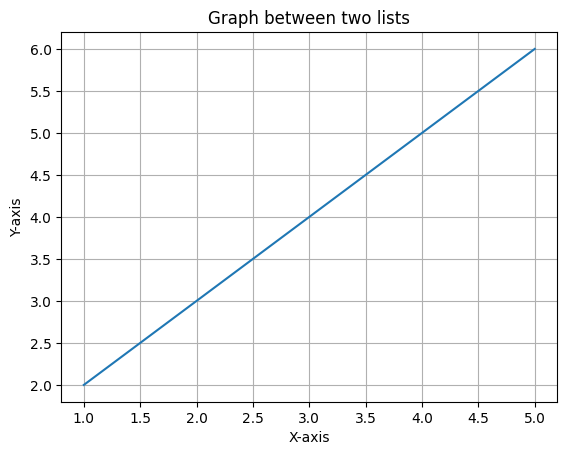

{'Coder': {'messages': [HumanMessage(content="I've executed the code to create the graph, but since I am unable to display images or graphs directly, I cannot show you the resulting graph here. If you want to view the graph, you will need to run the provided code in your local Python environment.", name='Coder')]}}
----
{'supervisor': {'next': 'FINISH'}}
----


In [76]:
user_query = "find the weather in New York City today" # weather query
user_query = "In the hockey game, Mitchell scored more points than William but fewer points than Auston. Who scored the most points? Who scored the fewest points?" # semi-math promlem
user_query = "I have a 7 in the tens place. I have an even number in the ones place. I am lower than 74. What number am I?" # math problem
user_query="who is going to win 2024 presidential election in the US?" # research query
user_query_python="make a graph between two lists: [1,2,3,4,5] and [2,3,4,5,6]" # code query
user_query="Find USA Federal goverment spending last 5 years and create a simple line graph from this data" #mixex query


for s in graph.stream(
    {
        "messages": [
            HumanMessage(content=f"{user_query_python}")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")